In [1]:
import sys
sys.path.extend(["../../../../"])

In [2]:
import numpy as np
from onsager.crystal import Crystal
from onsager.crystalStars import zeroclean
from onsager.OnsagerCalc import *
from onsager.crystal import DB_disp, DB_disp4, pureDBContainer, mixedDBContainer
from onsager.DB_structs import dumbbell, SdPair, jump, connector

from scipy.constants import physical_constants
from scipy.optimize import least_squares
kB = physical_constants['Boltzmann constant in eV/K'][0]
from matplotlib import pyplot as plt
import scipy.stats as spstats
from collections import defaultdict

import pickle

In [3]:
%%time
with open("FeMn_Onsg.pkl","rb") as fl:
    onsagercalculator = pickle.load(fl)

CPU times: user 9min 13s, sys: 4.42 s, total: 9min 17s
Wall time: 9min 13s


In [13]:
count = 0
for star in onsagercalculator.thermo.stars[:onsagercalculator.thermo.mixedstartindex]:
    print(count)
    db = star[0].db
    print("Dumbbell orientation: {}".format(np.round(
        onsagercalculator.pdbcontainer.iorlist[db.iorind][1], decimals=4)-0.))
    print("Dumbbell location relative to solute: {}".format(
    np.dot(onsagercalculator.crys.lattice, db.R)))
    print()
    count += 1

0
Dumbbell orientation: [ 0.1782  0.     -0.1782]
Dumbbell location relative to solute: [0. 0. 0.]

1
Dumbbell orientation: [ 0.1782 -0.1782  0.    ]
Dumbbell location relative to solute: [-0.14155 -0.14155  0.14155]

2
Dumbbell orientation: [ 0.1782 -0.1782  0.    ]
Dumbbell location relative to solute: [-0.14155  0.14155  0.14155]

3
Dumbbell orientation: [ 0.1782  0.     -0.1782]
Dumbbell location relative to solute: [0.2831 0.     0.    ]

4
Dumbbell orientation: [ 0.1782  0.     -0.1782]
Dumbbell location relative to solute: [0.     0.2831 0.    ]

5
Dumbbell orientation: [ 0.1782  0.     -0.1782]
Dumbbell location relative to solute: [ 0.2831 -0.2831  0.    ]

6
Dumbbell orientation: [ 0.1782  0.     -0.1782]
Dumbbell location relative to solute: [0.2831 0.     0.2831]

7
Dumbbell orientation: [ 0.1782  0.     -0.1782]
Dumbbell location relative to solute: [ 0.2831  0.     -0.2831]

8
Dumbbell orientation: [ 0.1782 -0.1782  0.    ]
Dumbbell location relative to solute: [-0.42465 

In [66]:
name_to_themo_star = {"1nnA":1, "1nnB":2, "2nnA":4, "2nnB":3, "3nnA":6,"3nnB":5,"3nnC":7,
       "4nnA":10,"4nnB":11,"4nnC":9, "4nnD":8, "5nnA":12, "5nnB":13}

In [68]:
# sorting out the jumps with the nomenclatures
jmpdict = {"1nnA_2nnA":[], "1nnA_2nnB":[], "1nnA_3nnB":[], "1nnA_3nnC":[], "1nnB_2nnB":[], "1nnB_3nnB":[],
          "1nnB_5nnB":[], "2nnA_4nnC":[], "2nnB_4nnB":[], "2nnB_4nnC":[]}
# Now identify the jumps and put them into the dictionaries
for jlistind, jlist in enumerate(onsagercalculator.jnet1):
    jmp = jlist[0]
    state1 = jmp.state1
    state2 = jmp.state2
    # if rigid jump, then continue
    if jmp.state1.db.iorind == jmp.state2.db.iorind:
        continue
    star1 = onsagercalculator.kinetic.complexIndexdict[state1][1]
    star2 = onsagercalculator.kinetic.complexIndexdict[state2][1]
    
    if star1 in onsagercalculator.thermo2kin and star2 in onsagercalculator.thermo2kin:
        thermo_star1 = onsagercalculator.thermo.complexIndexdict[state1][1]
        thermo_star2 = onsagercalculator.thermo.complexIndexdict[state2][1]
        name1 = ""
        name2 = ""
        #Now see which categories the states belong to
        star1found = False
        count1 = 0
        star2found = False
        count2 = 0
        for (key, value) in name_to_themo_star.items():
            if thermo_star1==value:
                star1found = True
                count1 += 1
                name1 = key
            if thermo_star2==value:
                star2found = True
                count2 += 1
                name2 = key
        # just to ensure we don't have any multiple counting business going on.
        if count1>1:
            print(thermo_star1)
        if count2>1:
            print(thermo_star2)
        # Now concatenate names
        jname = name1+"_"+name2
#         print(jname)
        jnameRev = name2+"_"+name1
        try:
            jmpdict[jname].append(jlistind)
        except:
            try:
                # maybe the jump we have is the reverse of what we stored as the label in the dictionary?
                jmpdict[jnamerev].append(jlistind)
            
            except:    
                continue

jmpdict

{'1nnA_2nnA': [2],
 '1nnA_2nnB': [5],
 '1nnA_3nnB': [6],
 '1nnA_3nnC': [3],
 '1nnB_2nnB': [4],
 '1nnB_3nnB': [7],
 '1nnB_5nnB': [1],
 '2nnA_4nnC': [9],
 '2nnB_4nnB': [10],
 '2nnB_4nnC': [8]}

In [69]:
E_f_pdb = 4.081701163
name_to_en =\
{"1nnA":-2082.04436416,"1nnB":-2082.24287998,"2nnA":-2081.93194878,"2nnB":-2082.02050066,"3nnA":-2081.87795528,
"3nnB":-2081.94900210,"3nnC":-2081.94643601,"4nnA":-2081.90793186,"4nnB":-2081.96094539,"4nnC":-2081.93724321,
"5nnA":-2081.93328589,"5nnB":-2081.95048841}

In [70]:
E_sup_pdb = -2081.44451396
E_sup_solute = -2077.71045687 
E_bulk = -2077.21734574  #E_bulk is the same as E_ref
name_to_Ef = defaultdict(float)
for (key, E_IB) in name_to_en.items():
    # get the binding energy first
    Eb = -E_IB + E_sup_pdb + E_sup_solute - E_bulk
    # Next, get the formation energy (relative to solute formation energy)
    name_to_Ef[key] = E_f_pdb - Eb
name_to_Ef["4nnD"] = name_to_Ef["4nnA"]/3. + name_to_Ef["4nnB"]/3. + name_to_Ef["4nnC"]/3.

In [71]:
# The complex energies are set. Now, we set the mixed dumbbell energies
E_b_mdb = 2082.49273533 + E_sup_pdb + E_sup_solute - E_bulk
E_f_mdb = E_f_pdb - E_b_mdb
E_f_mdb - E_f_pdb

-0.5551102399995216

In [72]:
# J_2_KRA_dumbbell_dumbbell       -2081.1091              4.4447 Johnson
# J_1_KRA_dumbbell_dumbbell       -2080.8336              4.4447 rot 
# J_2_KRA_dumbbell_dumbbell       -2080.6599              4.4447 rigid
# J_2_KRA_0nnA_0nnA               -2082.1767              5.9297 Johnsom
# J_2_KRA_0nnA_0nnA               -2082.17906295          5.9297 rotation
# J_2_KRA_0nnA_0nnA               -2081.8452              5.9297 rigid
# J_2_KRA_0nnA_1nnB               -2082.0446              4.4447 asn-disn
# J_3_1nnA_2nnA                   -2081.6931              4.4447
# J_3_1nnA_2nnB                   -2081.6706              4.4447
# J_3_1nnA_3nnB                   -2081.6771              4.4447
# J_3_1nnA_3nnC                   -2081.6764              4.4447
# J_3_1nnB_2nnB                   -2081.8645              4.4447
# J_3_1nnB_3nnB                   -2081.7221              4.4447
# J_3_1nnB_5nnB                   -2081.7316              4.4447
# J_3_2nnA_4nnC                   -2081.5549              4.4447
# J_3_2nnB_4nnB                   -2081.6867              4.4447
# J_3_2nnB_4nnC                   -2081.6444              4.4447


Jname_2_TS_en = {"1nnA_2nnA": -2081.6931, "1nnA_2nnB": -2081.6706, "1nnA_3nnB": -2081.6771,
                 "1nnA_3nnC": -2081.6764, "1nnB_2nnB": -2081.8645, "1nnB_3nnB": -2081.7221,
                 "1nnB_5nnB": -2081.7316, "2nnA_4nnC": -2081.5549, "2nnB_4nnB": -2081.6867, 
                 "2nnB_4nnC": -2081.6444}

In [73]:
# Now, we have to find the TS energies.
Jname_2_ef_ts = defaultdict(float)
for (key, E_IB) in Jname_2_TS_en.items():
    Eb = -E_IB + E_sup_pdb + E_sup_solute - E_bulk
    # Next, get the formation energy (relative to solute formation energy)
    Jname_2_ef_ts[key] = E_f_pdb - Eb

In [74]:
Jname_2_mig = defaultdict(float)
for (key, TS_en) in Jname_2_ef_ts.items():
    initstar = key[:4]
    finstar = key[5:]
    Jname_2_mig[key] = (TS_en - name_to_Ef[initstar], TS_en - name_to_Ef[finstar])

In [75]:
# omega2 and omega43 Johnson jumps
E_IB_43, E_IB_2 = -2082.0446, -2082.1767
Eb_43, Eb_2 = -E_IB_43 + E_sup_pdb + E_sup_solute - E_bulk, -E_IB_2 + E_sup_pdb + E_sup_solute - E_bulk 
# Next, get the formation energy (relative to solute formation energy)
ef_ts_43 = E_f_pdb - Eb_43
ef_ts_2 = E_f_pdb - Eb_2
print(ef_ts_2, ef_ts_43)
print(ef_ts_2-E_f_mdb)
print(ef_ts_43 - E_f_mdb, ef_ts_43 - name_to_Ef["1nnB"])

3.8426262530004553 3.9747262530002647
0.31603532999997697
0.44813532999978634 0.19827997999982472


In [76]:
# omega2 rigid translation
E_IB_2_rigid = -2081.8452
Eb_2_rigid = -E_IB_2_rigid + E_sup_pdb + E_sup_solute - E_bulk
ef_ts_2_rigid = E_f_pdb - Eb_2_rigid
print(ef_ts_2_rigid-E_f_mdb)
print(len(onsagercalculator.jnet2))

0.647535329999755
3


In [77]:
# omega2 on-site rotation
E_IB_2_rot = -2082.1790629
Eb_2_rot = -E_IB_2_rot + E_sup_pdb + E_sup_solute - E_bulk
ef_ts_2_rot = E_f_pdb - Eb_2_rot
print(ef_ts_2_rot-E_f_mdb)
print(len(onsagercalculator.jnet2))

0.3136724299997695
3


In [83]:
# get the SCMF PDC data from the file to compare to
temp = []
pdcr = []
with open("PDC_ratio_Mn.dat", "r") as fl:
    for line in fl:
        arr = line.split()
        temp.append(float(arr[0]))
        pdcr.append(float(arr[1]))
temp = np.array(temp)
pdcr = np.array(pdcr)

drag = []
with open("DragRatio_Mn.dat","r") as fl:
    for line in fl:
        arr = line.split()
        drag.append(float(arr[0]))
drag = np.array(drag)

In [84]:
temp.shape[0], pdcr.shape[0], drag.shape[0]

(381, 381, 381)

## Mn Thermodynamic data

In [85]:
# Jump rates and energy barriers set. Now, let's set the calculations up.
vu0 = 4.4447
vu2 = 5.9297
Dconv=1e-2
predb0, enedb0 = np.ones(1)*np.exp(0.050), np.array([E_f_pdb])

# We'll measure every formation energy relative to the solute formation energy.
preS, eneS = np.ones(1), np.array([0.0])

# Next, interaction or the excess energies and pre-factors for solutes and dumbbells.
preSdb, eneSdb = np.ones(onsagercalculator.thermo.mixedstartindex), \
                 np.zeros(onsagercalculator.thermo.mixedstartindex)
# Now, we go over the necessary stars and assign interaction energies
for (key, index) in name_to_themo_star.items():
    eneSdb[index] = name_to_Ef[key] - E_f_pdb

predb2, enedb2 = np.ones(1), np.array([E_f_mdb])

# Transition state energies - For omega0, omega2 and omega43, the first type is the Johnson jump,
# and the second one is the Rigid jump.

# Omega0 TS eneriges
# taken directly from the paper
preT0, eneT0 = Dconv*vu0*np.ones(1), np.array([E_f_pdb + 0.33541396, E_f_pdb + 0.61091396, E_f_pdb + 0.784315123])

# Omega2 TS energies
Nj2 = len(onsagercalculator.jnet2)
preT2, eneT2 = Dconv*vu2*np.ones(Nj2), np.array([ef_ts_2, ef_ts_2_rigid, ef_ts_2_rot])

# Omega43 TS energies
preT43, eneT43 = Dconv*vu0*np.ones(1), np.array([ef_ts_43])

# Omega1 TS energies
preT1 = Dconv*vu0*np.ones(len(onsagercalculator.jnet1))
eneT1 = np.array([eneT0[i] for i in onsagercalculator.om1types])
# Now, we go over the jumps that are provided and make the necessary changes
for (key, index) in jmpdict.items():
    eneT1[index] = Jname_2_ef_ts[key]
eneT1[0] = 0.0
# print(eneT1)

data_Mn = {"puredb_data":(predb0, enedb0), "mixed_db_data":(predb2, enedb2), "omega0_data":(preT0, eneT0),
          "omega2_data":(preT2, eneT2),"omega43_data":(preT43, eneT43), "omega1_data":(preT1, eneT1),
          "S-db_interaction_data":(preSdb, eneSdb)}

In [86]:
from tqdm import tqdm

In [90]:
# Then we calculate the transport coefficients

diff_aa_Mn = np.zeros(len(temp))
diff_ab_Mn = np.zeros(len(temp))
diff_bb = np.zeros(len(temp))
diff_bb_non_loc = np.zeros(len(temp))

start = time.time()
for i in tqdm(range(len(temp)), position=0, leave=True):
    T = temp[i]
    kT = kB*T
    bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
        onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                               preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)
    # get the probabilities and other data from L_ij
    L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
    onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)
    
    L_aa = L_uc_aa + L_c_aa
    L_bb = L_uc_bb + L_c_bb
    L_ab = L_uc_ab + L_c_ab
    
    diff_aa_Mn[i] = L_aa[0][0]
    diff_ab_Mn[i] = L_ab[0][0]
    diff_bb[i] = L_bb[0][0]
    diff_bb_non_loc[i] = L0bb[0][0]
    
print(time.time() - start)

100%|██████████| 381/381 [27:00<00:00,  4.25s/it]

1620.7255127429962


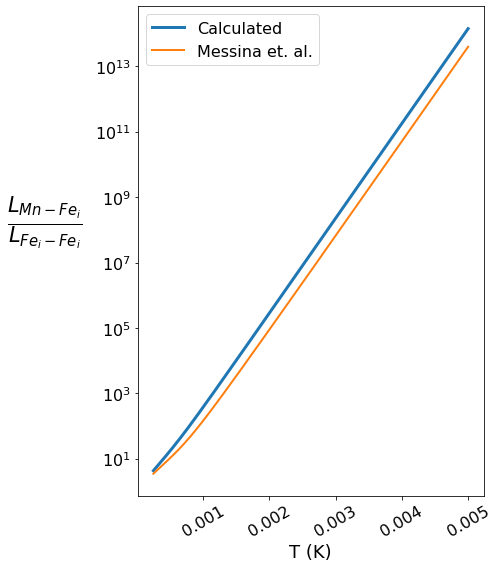

In [93]:
plt.figure(figsize=(7,8))
# plt.semilogy(1./temp, diff_ab_Mn/(diff_bb_non_loc), marker="o", label="Calculated-2.0THz", linewidth=3, ms=10)
plt.semilogy(1./temp, diff_ab_Mn/(diff_bb_non_loc), label="Calculated", linewidth=3)
plt.semilogy(1./temp, pdcr, linewidth=2,
             label="Messina et. al.")
plt.xlabel("T (K)", fontsize=18)
plt.ylabel(r"$\frac{L_{Mn-Fe_i}}{L_{Fe_i-Fe_i}}$", fontsize=30, rotation = 0, labelpad=50)
# plt.legend(loc="best", fontsize=16)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=16, rotation = 30)
plt.yticks(fontsize=16)
# plt.xlim(200, 1301)
plt.tight_layout()
plt.legend(fontsize=16)

# plt.savefig("pdcr_Mn_Fe_log.png")

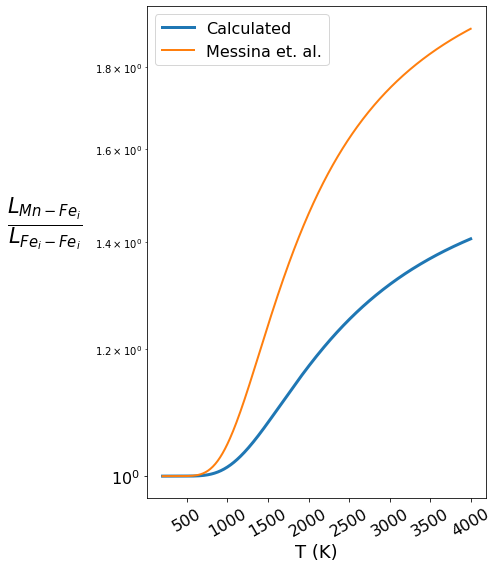

In [94]:
plt.figure(figsize=(7,8))
# plt.semilogy(1./temp, diff_ab_Mn/(diff_bb_non_loc), marker="o", label="Calculated-2.0THz", linewidth=3, ms=10)
plt.semilogy(temp, diff_ab_Mn/diff_aa_Mn, label="Calculated", linewidth=3)
plt.semilogy(temp, drag, linewidth=2,
             label="Messina et. al.")
plt.xlabel("T (K)", fontsize=18)
plt.ylabel(r"$\frac{L_{Mn-Fe_i}}{L_{Fe_i-Fe_i}}$", fontsize=30, rotation = 0, labelpad=50)
# plt.legend(loc="best", fontsize=16)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize=16, rotation = 30)
plt.yticks(fontsize=16)
# plt.xlim(200, 1301)
plt.tight_layout()
plt.legend(fontsize=16)

# plt.savefig("pdcr_Mn_Fe_log.png")

In [98]:
import h5py
with h5py.File("Mn_data.h5","w") as fl:
    fl.create_dataset("diff_aa", data=diff_aa_Mn)
    fl.create_dataset("diff_ab", data=diff_ab_Mn)
    fl.create_dataset("diff_bb_nl", data=diff_bb_non_loc)
    fl.create_dataset("diff_bb", data=diff_bb)
    fl.create_dataset("Temp", data=temp)

In [96]:
# Now let's do the infinite temeperature limit
kT = np.inf
bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
    onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                           preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)
#     bFdicts[i] = [bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4]
# get the probabilities and other data from L_ij
L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)

L_aa = L_uc_aa + L_c_aa
L_bb = L_uc_bb + L_c_bb
L_ab = L_uc_ab + L_c_ab

In [97]:
L_ab[0][0]/L_aa[0][0]

1.6652483153248634